$need \:to \:add \:labels$

https://www.kaggle.com/datasets/elikplim/forest-fires-data-set

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)

library(knitr)
library(kknn)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in library(kknn): there is no package called ‘kknn’


- Read and wrangle your data.

In [ ]:
url <- "https://raw.githubusercontent.com/perdomopatrick/group7/main/forestfires.csv"
data <- read_csv(url)

clean_data <- data|>
      select(-X,-Y,-month,-day)

print_data <- head(clean_data, n= 5)

kable_clean_data <- knitr::kable(print_data, "pipe", 
                                 caption = "Shows all variables calculated in each of the fires in the dataset, with the columns being the variables we are analyzing.",
                                label = "Table 1")


#kable_clean_data

<center><table> Table 1: 5 First Lines of Dataset</table></center>

| FFMC|  DMC|    DC| ISI| temp| RH| wind| rain| area|
|----:|----:|-----:|---:|----:|--:|----:|----:|----:|
| 86.2| 26.2|  94.3| 5.1|  8.2| 51|  6.7|  0.0|    0|
| 90.6| 35.4| 669.1| 6.7| 18.0| 33|  0.9|  0.0|    0|
| 90.6| 43.7| 686.9| 6.7| 14.6| 33|  1.3|  0.0|    0|
| 91.7| 33.3|  77.5| 9.0|  8.3| 97|  4.0|  0.2|    0|
| 89.3| 51.3| 102.2| 9.6| 11.4| 99|  1.8|  0.0|    0|

- Split data into training and test-set.

In [3]:
set.seed(1133) 

data_split <- initial_split(clean_data, prop = 0.75, strata = area)
data_training <- training(data_split)
data_testing <- testing(data_split)

- Make a table or two for the mean statistics of your training set and/or test set.

In [4]:
mean_stats_train <- data_training|>
    summarise(across(everything(), ~mean(.x, na.rm = TRUE)))|>
    pivot_longer(cols = everything(), 
                 names_to = "Variables", 
                 values_to = "Mean")

# converts tibble to kable
kable_mean_stats_train <- knitr::kable(mean_stats_train, "pipe", 
                                 caption = "Mean of all the variables being analyzed using the values from Figure 1.",
                                label = "Table 2")

kable_mean_stats_train



Table: Mean of all the variables being analyzed using the values from Figure 1.

|Variables |        Mean|
|:---------|-----------:|
|FFMC      |  90.6772021|
|DMC       | 109.9064767|
|DC        | 541.4875648|
|ISI       |   9.0487047|
|temp      |  18.9655440|
|RH        |  44.1502591|
|wind      |   4.0261658|
|rain      |   0.0253886|
|area      |  14.1083161|

<center><table> Table 2: Mean of all the variables being analyzed using the values from Figure 1.</table></center>

|Variables |        Mean|
|:---------|-----------:|
|FFMC      |  90.6772021|
|DMC       | 109.9064767|
|DC        | 541.4875648|
|ISI       |   9.0487047|
|temp      |  18.9655440|
|RH        |  44.1502591|
|wind      |   4.0261658|
|rain      |   0.0253886|
|area      |  14.1083161|

- Use the forward selection method to choose the best predictor variables for your response. (Check 6.8.3 for the forward selection method)
- https://datasciencebook.ca/classification2.html#forward-selection-in-r

In [5]:
set.seed(1133) 
#install.packages("kknn")

names <- colnames(data_training |> select(-area))

results <- tibble(size = integer(), 
                     model_string = character(), 
                     RMSE = numeric())

# create a model specification for regression KNN
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

# create a 5-fold cross-validation object
fire_vfold <- vfold_cv(data_training, v = 5, strata = area)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
  # for every predictor still not added yet
  rmses <- list()
  models <- list()
  for (j in 1:length(names)) {
    # create a model string for this combination of predictors
    preds_new <- c(selected, names[[j]])
    model_string <- paste("area", "~", paste(preds_new, collapse="+"))

    # create a recipe from the model string
    fire_recipe <- recipe(as.formula(model_string), 
                            data = data_training) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

    # tune the KNN regressor with these predictors, 
    # and collect the RMSE for the best K
    rmse <- workflow() |>
      add_recipe(fire_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = fire_vfold, grid = 10) |>
      collect_metrics() |>
      filter(.metric == "rmse") |>
      summarize(mx = min(mean))
    rmse <- rmse$mx |> unlist()

    # add this result to the dataframe
    rmses[[j]] <- rmse
    models[[j]] <- model_string
  }
  jstar <- which.min(unlist(rmses))
  results <- results |> 
    add_row(size = i, 
            model_string = models[[jstar]], 
            RMSE = rmses[[jstar]])
  selected <- c(selected, names[[jstar]])
  names <- names[-jstar]
}

# converts tibble to kable
kable_results <- knitr::kable(results, "pipe", 
                                 caption = "Result of forward selection, displaying the accuracy of the variables added by the forward selection procedure.",
                                label = "Table 3")

kable_results

! Fold1: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold2: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 9 r...

! Fold3: internal:
  There were 10 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(truth = area,...
    na_rm)`.
  ℹ In group 1: `neighbors = 1`.
  Caused by warning:
  ! A correlation computation is required, but `estimate` is c...
  ℹ Run `dplyr::last_dplyr_warni



Table: Result of forward selection, displaying the accuracy of the variables added by the forward selection procedure.

| size|model_string                             |     RMSE|
|----:|:----------------------------------------|--------:|
|    1|area ~ RH                                | 60.67079|
|    2|area ~ RH+rain                           | 60.69569|
|    3|area ~ RH+rain+DMC                       | 64.84574|
|    4|area ~ RH+rain+DMC+wind                  | 64.64394|
|    5|area ~ RH+rain+DMC+wind+ISI              | 63.80702|
|    6|area ~ RH+rain+DMC+wind+ISI+DC           | 64.38295|
|    7|area ~ RH+rain+DMC+wind+ISI+DC+FFMC      | 64.91035|
|    8|area ~ RH+rain+DMC+wind+ISI+DC+FFMC+temp | 66.77548|

<div align="center"> Table 3: Result of forward selection, displaying the accuracy of the variables added by the forward selection procedure. </div>

| size|model_string                             |     RMSE|
|----:|:----------------------------------------|--------:|
|    1|area ~ RH                                | 60.67079|
|    2|area ~ RH+rain                           | 60.69569|
|    3|area ~ RH+rain+DMC                       | 64.84574|
|    4|area ~ RH+rain+DMC+wind                  | 64.64394|
|    5|area ~ RH+rain+DMC+wind+ISI              | 63.80702|
|    6|area ~ RH+rain+DMC+wind+ISI+DC           | 64.38295|
|    7|area ~ RH+rain+DMC+wind+ISI+DC+FFMC      | 64.91035|
|    8|area ~ RH+rain+DMC+wind+ISI+DC+FFMC+temp | 66.77548|

- Display the distributions of each of these variables using histograms (Hint: use facet_wrap() or facet_grid() to get all the plots to show together)- 


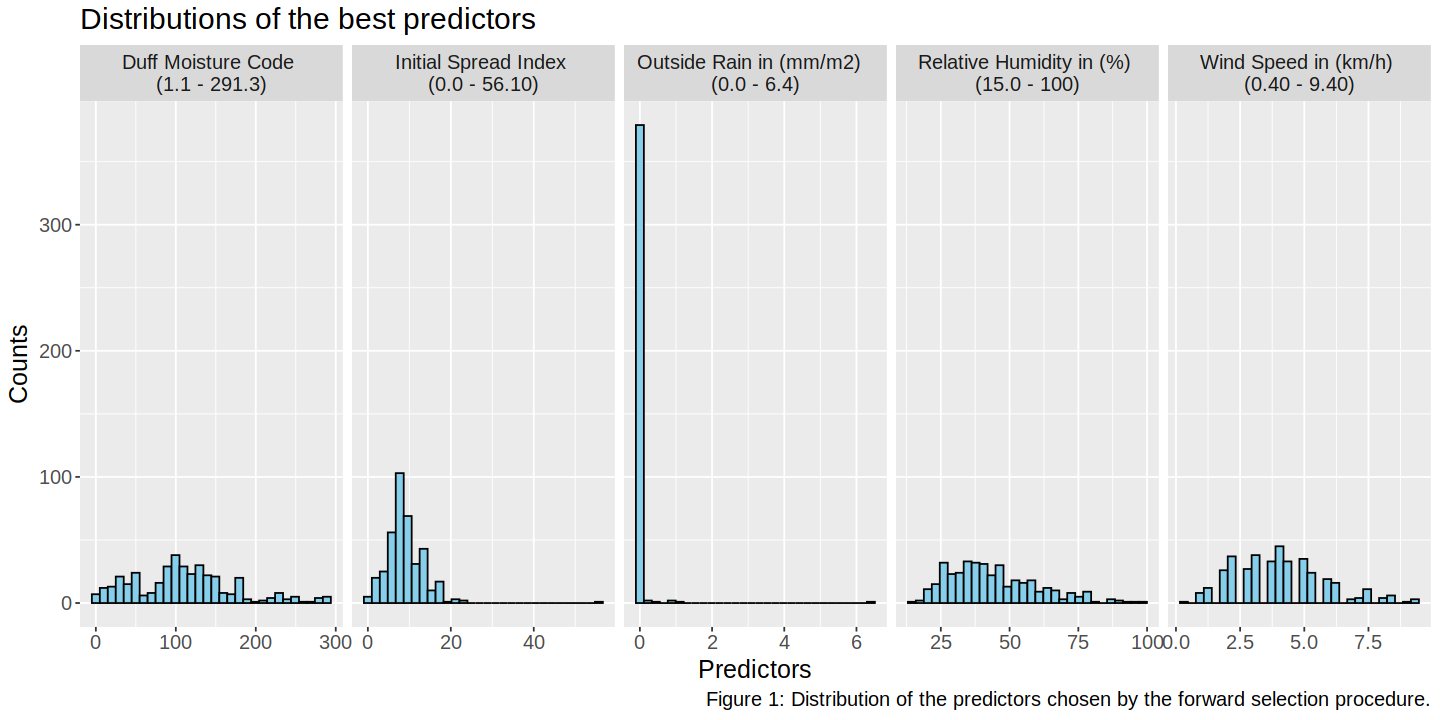

In [6]:
options(repr.plot.width = 12, repr.plot.height = 6)

melted_data <- data_training |>
    select(-FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

predictor_labels <- c(RH = "Relative Humidity in (%) \n(15.0 - 100)",
                   rain = "Outside Rain in (mm/m2)  \n(0.0 - 6.4)",
                     DMC="Duff Moisture Code \n(1.1 - 291.3)",
                     wind="Wind Speed in (km/h) \n(0.40 - 9.40)",
                     ISI="Initial Spread Index \n(0.0 - 56.10)")

distribution_plot <- melted_data |>
    ggplot(aes(x = values)) + 
    geom_histogram(position = 'identity', bins = 30, fill = "skyblue", color = "black") +
    labs(x = "Predictors",
         y = "Counts",
         title = "Distributions of the best predictors",
         caption = "Figure 1: Distribution of the predictors chosen by the forward selection procedure.") +
    facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
    theme(text = element_text(size = 15))

distribution_plot

Visualization of the predictors vs Area before using model

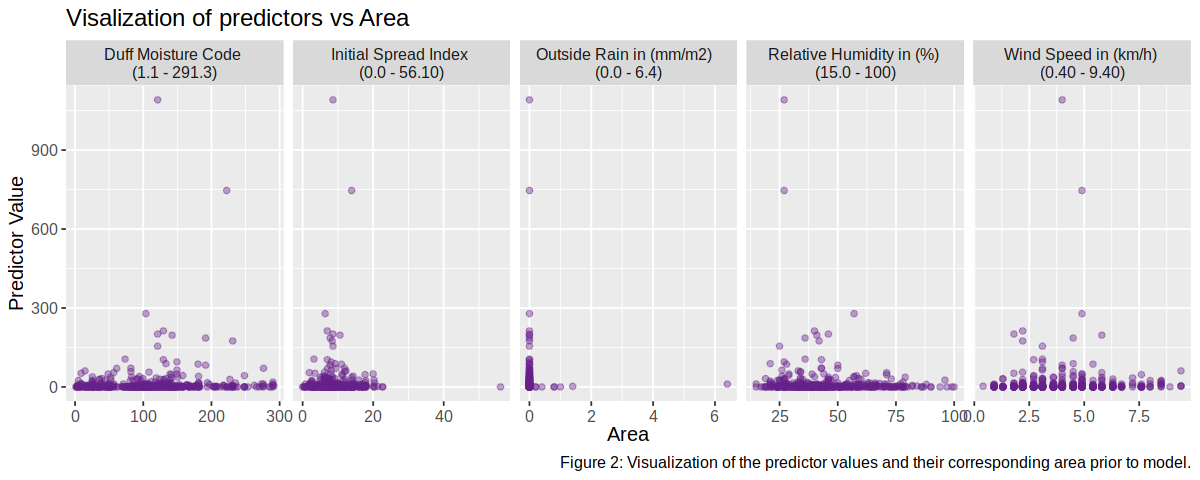

In [7]:
# all the data without the irrelevant columns pivoted longer to be used by facet_grid()
long_data <- data |>
    select(-X, -Y, -month, -day, -FFMC, -DC, -temp) |> 
    pivot_longer(cols = -area,
                 names_to = "predictors",
                 values_to = "values")

options(repr.plot.width = 10, repr.plot.height = 4)

# Initial graph before predictions
initial_plot <- ggplot(long_data, aes(x = values, y = area)) +
  geom_point(alpha = 0.4, color = "darkorchid4") +
  xlab("Area") +
  ylab("Predictor Value") +
 facet_grid(cols = vars(predictors), scales = "free",
               labeller = labeller(predictors = predictor_labels)) +
  ggtitle(paste0("Visalization of predictors vs Area")) + 
  theme(text = element_text(size = 12)) +
  labs(caption = "Figure 2: Visualization of the predictor values and their corresponding area prior to model.")

initial_plot

Tune your model to choose the best k-neighbours using cross validation.

In [8]:
set.seed(1133) 

# recipe with all predictors
fire_recipe <- recipe(area ~ RH + rain + DMC + wind + ISI, data = data_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# model for tuning
fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                  set_engine("kknn") |>
                  set_mode("regression")

fire_vfold <- vfold_cv(data_training, v = 5, strata = area)

# creates workflow from recipe + model
fire_wkflw <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(fire_spec)

gridvals <- tibble(neighbors = seq(1, 200))

# Filters for rmse
fire_results <- fire_wkflw |>
  tune_grid(resamples = fire_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

print_data <- head(fire_results, n= 5)

# converts tibble to kable
kable_fire_results <- knitr::kable(fire_results, "pipe", 
                                 caption = "Shows the RMSPE (mean) for all of the neighbours values (neighbors).",
                                label = "Table 4")

kable_fire_results



Table: Shows the RMSPE (mean) for all of the neighbours values (neighbors).

| neighbors|.metric |.estimator |     mean|  n|  std_err|.config                |
|---------:|:-------|:----------|--------:|--:|--------:|:----------------------|
|         1|rmse    |standard   | 79.83670|  5| 27.41421|Preprocessor1_Model001 |
|         2|rmse    |standard   | 80.88126|  5| 22.36697|Preprocessor1_Model002 |
|         3|rmse    |standard   | 74.79210|  5| 20.20362|Preprocessor1_Model003 |
|         4|rmse    |standard   | 71.53269|  5| 20.79333|Preprocessor1_Model004 |
|         5|rmse    |standard   | 66.91379|  5| 21.50735|Preprocessor1_Model005 |
|         6|rmse    |standard   | 65.15319|  5| 21.85641|Preprocessor1_Model006 |
|         7|rmse    |standard   | 62.53499|  5| 22.45633|Preprocessor1_Model007 |
|         8|rmse    |standard   | 60.91373|  5| 22.85362|Preprocessor1_Model008 |
|         9|rmse    |standard   | 60.48617|  5| 23.00040|Preprocessor1_Model009 |
|        10|rmse   

<div align="center"> Table 4: Shows the RMSPE (mean) for 5 of the neighbours values (neighbors).</div>

| neighbors|.metric |.estimator |     mean|  n|  std_err|.config                |
|---------:|:-------|:----------|--------:|--:|--------:|:----------------------|
|         1|rmse    |standard   | 79.83670|  5| 27.41421|Preprocessor1_Model001 |
|         2|rmse    |standard   | 80.88126|  5| 22.36697|Preprocessor1_Model002 |
|         3|rmse    |standard   | 74.79210|  5| 20.20362|Preprocessor1_Model003 |
|         4|rmse    |standard   | 71.53269|  5| 20.79333|Preprocessor1_Model004 |
|         5|rmse    |standard   | 66.91379|  5| 21.50735|Preprocessor1_Model005 |

In [9]:
# Gets mean
fire_min <- fire_results |>
  filter(mean == min(mean))

# converts tibble to kable
kable_fire_min <- knitr::kable(fire_min, "pipe", 
                                 caption = "Shows the neighbor value (neighbors) with the lowest RMSPE (mean)",
                                label = "Table 5")

kable_fire_min



Table: Shows the neighbor value (neighbors) with the lowest RMSPE (mean)

| neighbors|.metric |.estimator |     mean|  n| std_err|.config                |
|---------:|:-------|:----------|--------:|--:|-------:|:----------------------|
|       200|rmse    |standard   | 51.45783|  5| 25.3164|Preprocessor1_Model200 |

<div align="center"> Table 5: Shows the neighbor value (neighbors) with the lowest RMSPE (mean) </div>

| neighbors|.metric |.estimator |     mean|  n| std_err|.config                |
|---------:|:-------|:----------|--------:|--:|-------:|:----------------------|
|       200|rmse    |standard   | 51.45783|  5| 25.3164|Preprocessor1_Model200 |

We chose to check the k-neighbor values from 1 to 200 as it covers most of the possible k-neighbour values and the impact of the changing k-neighbors on the RMSPE decreases the larger the range.

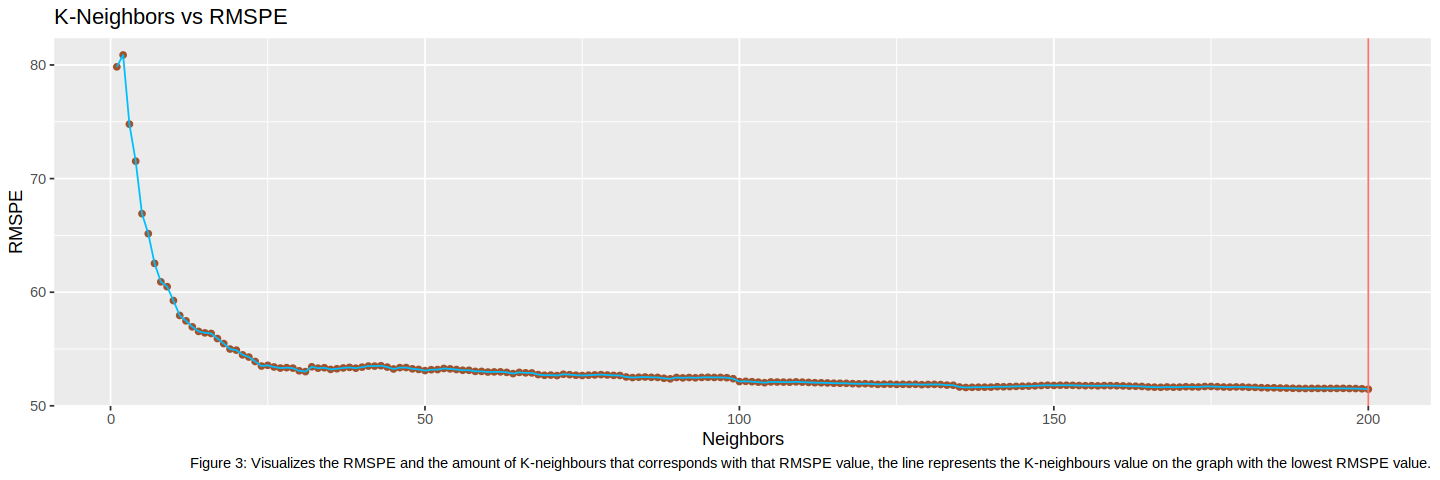

In [10]:
options(repr.plot.width = 12, repr.plot.height = 4)

# Visualization of best neighbors
fire_neighbors <- fire_results |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_point(colour = "sienna") +
  geom_line(colour = "deepskyblue") +
  geom_vline(aes(xintercept = fire_min$neighbors, colour = "red")) + # takes the neighbors value from min object
  labs(x = "Neighbors", 
       y = "RMSPE", 
       caption = "Figure 3: Visualizes the RMSPE and the amount of K-neighbours that corresponds with that RMSPE value, the line represents the K-neighbours value on the graph with the lowest RMSPE value.", 
       title ="K-Neighbors vs RMSPE") +
  theme(legend.position="none")

fire_neighbors

Now perform the knn-regression on your test set.

In [11]:
# gets minimum k
kmin <- fire_min |> pull(neighbors)

# create model
new_fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

# create workflow
new_fire_fit <- workflow() |>
  add_recipe(fire_recipe) |>
  add_model(new_fire_spec) |>
  fit(data = data_training)

# gets new rmse estimate
new_fire_results <- new_fire_fit |>
  predict(data_testing) |>
  bind_cols(data_testing) |>
  metrics(truth = area, estimate = .pred) |>
  filter(.metric == 'rmse')

kable_new_fire_results <- knitr::kable(new_fire_results, "pipe", 
                                 caption = "RMSPE value as determined by the lowest k-neighbours value",
                                label = "Table 6")

kable_new_fire_results



Table: RMSPE value as determined by the lowest k-neighbours value

|.metric |.estimator | .estimate|
|:-------|:----------|---------:|
|rmse    |standard   |  26.18096|

<div align="center"> Table 6: RMSPE value as determined by the lowest k-neighbours value </div>

|.metric |.estimator | .estimate|
|:-------|:----------|---------:|
|rmse    |standard   |  26.18096|

Visualization of the model predictions

In [12]:
# makes predictions using workflow
fire_preds <- new_fire_fit |>
  predict(data_testing) |>
  bind_cols(data_testing)

kable_fire_preds <- knitr::kable(fire_preds, "pipe", 
                                 caption = "Predicted areas for the testing variables (.pred column ) given the other predictors (columns FFMC to rain) and their real area (area column)",
                                label = "Table 7")

kable_fire_preds




Table: Predicted areas for the testing variables (.pred column ) given the other predictors (columns FFMC to rain) and their real area (area column)

|    .pred| FFMC|   DMC|    DC|  ISI| temp|  RH| wind| rain|   area|
|--------:|----:|-----:|-----:|----:|----:|---:|----:|----:|------:|
| 12.99935| 86.2|  26.2|  94.3|  5.1|  8.2|  51|  6.7|  0.0|   0.00|
| 16.58805| 91.0| 129.5| 692.6|  7.0| 13.1|  63|  5.4|  0.0|   0.00|
| 16.84335| 92.5|  88.0| 698.6|  7.1| 22.8|  40|  4.0|  0.0|   0.00|
|  8.25985| 63.5|  70.8| 665.3|  0.8| 17.0|  72|  6.7|  0.0|   0.00|
| 17.85255| 90.9| 126.5| 686.5|  7.0| 21.3|  42|  2.2|  0.0|   0.00|
| 18.40595| 93.3| 141.2| 713.9| 13.9| 22.9|  44|  5.4|  0.0|   0.00|
| 14.14700| 91.7|  35.8|  80.8|  7.8| 15.1|  27|  5.4|  0.0|   0.00|
|  8.36230| 90.0|  41.5| 682.6|  8.7| 11.3|  60|  5.4|  0.0|   0.00|
| 15.28180| 88.1|  25.7|  67.6|  3.8| 14.1|  43|  2.7|  0.0|   0.00|
| 14.54950| 94.2|  62.3| 442.9| 11.0| 23.0|  36|  3.1|  0.0|   0.00|
| 13.76515| 87.6|  5

<div align="center"> Table 7: Predicted areas for the testing variables (.pred column ) given the other predictors (columns FFMC to rain) and their real area (area column)</div>


|    .pred| FFMC|   DMC|    DC|  ISI| temp|  RH| wind| rain|   area|
|--------:|----:|-----:|-----:|----:|----:|---:|----:|----:|------:|
| 12.99935| 86.2|  26.2|  94.3|  5.1|  8.2|  51|  6.7|  0.0|   0.00|
| 16.58805| 91.0| 129.5| 692.6|  7.0| 13.1|  63|  5.4|  0.0|   0.00|
| 16.84335| 92.5|  88.0| 698.6|  7.1| 22.8|  40|  4.0|  0.0|   0.00|
|  8.25985| 63.5|  70.8| 665.3|  0.8| 17.0|  72|  6.7|  0.0|   0.00|
| 17.85255| 90.9| 126.5| 686.5|  7.0| 21.3|  42|  2.2|  0.0|   0.00|
| 18.40595| 93.3| 141.2| 713.9| 13.9| 22.9|  44|  5.4|  0.0|   0.00|
| 14.14700| 91.7|  35.8|  80.8|  7.8| 15.1|  27|  5.4|  0.0|   0.00|
|  8.36230| 90.0|  41.5| 682.6|  8.7| 11.3|  60|  5.4|  0.0|   0.00|
| 15.28180| 88.1|  25.7|  67.6|  3.8| 14.1|  43|  2.7|  0.0|   0.00|
| 14.54950| 94.2|  62.3| 442.9| 11.0| 23.0|  36|  3.1|  0.0|   0.00|
| 13.76515| 87.6|  52.2| 103.8|  5.0| 11.0|  46|  5.8|  0.0|   0.00|
| 17.04905| 90.2|  99.6| 631.2|  6.3| 21.5|  34|  2.2|  0.0|   0.00|
| 16.61815| 92.9| 137.0| 706.4|  9.2| 27.7|  24|  2.2|  0.0|   0.00|
| 11.14190| 90.3|  80.7| 730.2|  6.3| 17.8|  63|  4.9|  0.0|   0.00|
| 15.33375| 92.6|  46.5| 691.8|  8.8| 13.8|  50|  2.7|  0.0|   0.00|
| 17.03345| 90.2|  99.6| 631.2|  6.3| 20.8|  33|  2.7|  0.0|   0.00|
| 21.45910| 88.8| 147.3| 614.5|  9.0| 17.3|  43|  4.5|  0.0|   0.00|
| 10.28040| 84.2|   6.8|  26.6|  7.7|  6.7|  79|  3.1|  0.0|   0.00|
| 18.76050| 91.4| 142.4| 601.4| 10.6| 19.5|  39|  6.3|  0.0|   0.00|
| 19.04825| 94.8| 108.3| 647.1| 17.0| 18.6|  51|  4.5|  0.0|   0.00|
| 17.52825| 91.7| 114.3| 661.3|  6.3| 20.2|  45|  3.6|  0.0|   0.00|
| 14.25750| 91.7|  35.8|  80.8|  7.8| 17.4|  24|  5.4|  0.0|   0.00|
| 18.16670| 92.3|  85.3| 488.0| 14.7| 20.8|  32|  6.3|  0.0|   0.00|
| 20.90080| 91.4| 142.4| 601.4| 10.6| 18.2|  43|  4.9|  0.0|   0.00|
| 20.03975| 91.4| 142.4| 601.4| 10.6| 19.8|  39|  5.4|  0.0|   0.00|
| 20.03975| 91.4| 142.4| 601.4| 10.6| 19.8|  39|  5.4|  0.0|   0.00|
| 10.17910| 82.1|   3.7|   9.3|  2.9|  5.3|  78|  3.1|  0.0|   0.00|
| 16.02500| 92.5|  88.0| 698.6|  7.1| 20.3|  45|  3.1|  0.0|   0.00|
| 14.07255| 91.7|  35.8|  80.8|  7.8| 15.2|  27|  4.9|  0.0|   0.00|
| 18.09850| 92.4| 124.1| 680.7|  8.5| 22.5|  42|  5.4|  0.0|   0.00|
| 14.11985| 94.3|  85.1| 692.3| 15.9| 19.8|  50|  5.4|  0.0|   0.00|
| 15.09050| 91.4|  37.9| 673.8|  5.2| 15.9|  46|  3.6|  0.0|   0.00|
| 14.16805| 89.3|  51.3| 102.2|  9.6| 10.6|  46|  4.9|  0.0|   0.00|
| 15.28375| 88.1|  25.7|  67.6|  3.8| 14.9|  38|  2.7|  0.0|   0.00|
| 17.51670| 93.5| 139.4| 594.2| 20.3| 17.6|  52|  5.8|  0.0|   0.00|
| 18.04155| 91.0| 129.5| 692.6|  7.0| 21.7|  38|  2.2|  0.0|   0.43|
| 18.14855| 94.8| 108.3| 647.1| 17.0| 17.4|  43|  6.7|  0.0|   1.07|
| 20.29630| 93.4| 145.4| 721.4|  8.1| 29.6|  27|  2.7|  0.0|   1.46|
| 16.78085| 93.4| 145.4| 721.4|  8.1| 28.6|  27|  2.2|  0.0|   1.61|
| 10.31530| 84.9|  18.2|  55.0|  3.0|  5.3|  70|  4.5|  0.0|   2.14|
| 19.35555| 96.0| 127.1| 570.5| 16.5| 23.4|  33|  4.5|  0.0|   2.51|
| 18.95815| 92.4| 124.1| 680.7|  8.5| 23.9|  32|  6.7|  0.0|   5.33|
| 19.38325| 93.9| 135.7| 586.7| 15.1| 20.8|  34|  4.9|  0.0|   6.96|
| 13.93575| 90.8|  41.9|  89.4|  7.9| 13.3|  42|  0.9|  0.0|   7.40|
| 16.60895| 95.2| 131.7| 578.8| 10.4| 24.2|  28|  2.7|  0.0|   8.68|
| 20.21360| 92.9| 137.0| 706.4|  9.2| 21.5|  15|  0.9|  0.0|  11.06|
| 17.98275| 91.0| 129.5| 692.6|  7.0| 20.7|  37|  2.2|  0.0|  17.20|
| 16.32465| 93.7|  80.9| 685.2| 17.9| 23.2|  26|  4.9|  0.0|  23.41|
| 14.25530| 90.6|  43.7| 686.9|  6.7| 18.4|  25|  3.1|  0.0|  24.23|
|  8.52825| 93.5| 139.4| 594.2| 20.3|  5.1|  96|  5.8|  0.0|  26.00|
| 16.57795| 90.1|  82.9| 735.7|  6.2| 15.4|  57|  4.5|  0.0|  37.71|
| 15.68500| 92.2|  81.8| 480.8| 11.9| 16.4|  43|  4.0|  0.0|  71.30|
| 20.41155| 93.5| 149.3| 728.6|  8.1| 27.8|  27|  3.1|  0.0|  95.18|
| 16.08475| 92.5| 121.1| 674.4|  8.6| 17.7|  25|  3.1|  0.0| 154.88|
| 20.07515| 91.4| 142.4| 601.4| 10.6| 19.6|  41|  5.8|  0.0| 196.48|
|  9.76125| 81.9|   3.0|   7.9|  3.5| 13.4|  75|  1.8|  0.0|   0.00|
| 15.25145| 88.0|  17.2|  43.5|  3.8| 15.2|  51|  2.7|  0.0|   0.00|
| 10.18345| 94.2| 122.3| 589.9| 12.9| 15.4|  66|  4.0|  0.0|  10.13|
| 20.08295| 93.1| 157.3| 666.7| 13.5| 28.7|  28|  2.7|  0.0|   0.00|
|  8.78650| 91.6| 112.4| 573.0|  8.9| 11.2|  84|  7.6|  0.0|   3.30|
| 21.39300| 94.3| 167.6| 684.4| 13.0| 21.8|  53|  3.1|  0.0|   6.54|
| 15.44075| 85.4|  25.4| 349.7|  2.6|  4.6|  21|  8.5|  0.0|  10.73|
| 15.18070| 85.4|  25.4| 349.7|  2.6|  5.1|  24|  8.5|  0.0|  24.77|
| 15.57880| 86.9|   6.6|  18.7|  3.2|  8.8|  35|  3.1|  0.0|   1.10|
| 15.67445| 91.6| 104.2| 474.9|  9.0| 25.3|  39|  0.9|  0.0|   8.00|
| 17.00240| 91.6| 100.2| 466.3|  6.3| 22.9|  40|  1.3|  0.0|   2.64|
| 15.78915| 90.4|  89.5| 290.8|  6.4| 14.3|  46|  1.8|  0.0|   0.90|
| 17.08590| 90.4|  93.3| 298.1|  7.5| 19.1|  39|  5.4|  0.0|   3.52|
| 17.39025| 91.1|  94.1| 232.1|  7.1| 19.2|  38|  4.5|  0.0|   0.00|
| 15.39900| 89.6|  84.1| 714.3|  5.7| 17.1|  53|  5.4|  0.0|   0.41|
| 16.67440| 92.4| 105.8| 758.1|  9.9| 16.0|  45|  1.8|  0.0|   0.00|
| 15.71990| 92.4| 105.8| 758.1|  9.9| 25.3|  27|  2.7|  0.0|   0.00|
| 20.69840| 92.6| 115.4| 777.1|  8.8| 24.3|  27|  4.9|  0.0|   0.00|
| 17.95820| 92.6| 115.4| 777.1|  8.8| 19.7|  41|  1.8|  0.0|   1.58|
| 17.15965| 92.8| 119.0| 783.5|  7.5| 21.6|  27|  2.2|  0.0|   0.00|
| 17.74130| 92.8| 119.0| 783.5|  7.5| 16.8|  28|  4.0|  0.0|   7.21|
| 17.89990| 90.7| 136.9| 822.8|  6.8| 12.9|  39|  2.7|  0.0|   2.18|
| 15.38600| 92.2| 102.3| 751.5|  8.4| 24.1|  27|  3.1|  0.0|   0.00|
| 16.18910| 92.2| 102.3| 751.5|  8.4| 23.5|  27|  4.0|  0.0|   3.33|
| 15.38600| 92.2| 102.3| 751.5|  8.4| 24.2|  27|  3.1|  0.0|   6.58|
| 17.90695| 91.2| 124.4| 795.3|  8.5| 17.1|  41|  2.2|  0.0|  11.22|
| 15.47025| 92.1|  87.7| 721.1|  9.5| 18.1|  54|  3.1|  0.0|   2.13|
| 16.99320| 91.6| 108.4| 764.0|  6.2| 18.0|  51|  5.4|  0.0|   0.00|
| 18.05565| 91.6| 108.4| 764.0|  6.2| 22.7|  35|  2.2|  0.0|   7.48|
| 11.05240| 91.5| 130.1| 807.1|  7.5| 12.2|  66|  4.9|  0.0|   6.10|
| 10.80540| 92.1|  99.0| 745.3|  9.6| 12.8|  64|  3.6|  0.0|   1.64|
| 15.42235| 92.1|  99.0| 745.3|  9.6| 18.7|  50|  2.2|  0.0|   5.97|
| 16.67930| 92.1|  99.0| 745.3|  9.6| 20.8|  35|  4.9|  0.0|  13.06|
| 16.46120| 92.5| 122.0| 789.7| 10.2| 19.7|  39|  2.7|  0.0|   0.00|
| 17.93440| 92.5| 122.0| 789.7| 10.2| 18.4|  42|  2.2|  0.0|   1.09|
| 17.33535| 91.9| 111.7| 770.3|  6.5| 15.9|  53|  2.2|  0.0|   2.93|
| 17.17855| 91.9| 111.7| 770.3|  6.5| 21.1|  35|  2.7|  0.0|   5.65|
| 11.38890| 92.0| 203.2| 664.5|  8.1| 10.4|  75|  0.9|  0.0|   0.00|
| 20.12705| 94.8| 222.4| 698.6| 13.9| 20.3|  42|  2.7|  0.0|   0.00|
| 15.66240| 90.3| 290.0| 855.3|  7.4| 10.3|  78|  4.0|  0.0|  18.30|
| 16.88220| 91.2|  94.3| 744.4|  8.4| 15.4|  57|  4.9|  0.0|  39.35|
| 10.25740| 18.7|   1.1| 171.4|  0.0|  5.2| 100|  0.9|  0.0|   0.00|
| 21.53700| 91.6| 273.8| 819.1|  7.7| 21.3|  44|  4.5|  0.0|  12.18|
| 13.29415| 90.9|  18.9|  30.6|  8.0| 11.6|  48|  5.4|  0.0|   0.00|
| 20.02605| 94.8| 227.0| 706.7| 12.0| 23.3|  34|  3.1|  0.0|  28.74|
| 15.98560| 91.1|  91.3| 738.1|  7.2| 20.7|  46|  2.7|  0.0|  30.18|
| 16.40915| 90.5|  96.7| 750.5| 11.4| 20.4|  55|  4.9|  0.0|   3.64|
| 21.77085| 90.7| 194.1| 643.0|  6.8| 21.3|  41|  3.6|  0.0|   0.00|
| 20.28775| 94.6| 212.1| 680.9|  9.5| 27.9|  27|  2.2|  0.0|   0.00|
| 21.29010| 90.3| 290.0| 855.3|  7.4| 19.9|  44|  3.1|  0.0|   7.80|
| 18.70540| 92.3|  96.2| 450.2| 12.1| 23.4|  31|  5.4|  0.0|   0.00|
| 19.74560| 93.7| 231.1| 715.1|  8.4| 26.4|  33|  3.6|  0.0|   0.00|
| 19.93665| 93.7| 231.1| 715.1|  8.4| 26.9|  31|  3.6|  0.0|   4.96|
| 20.92155| 91.6| 248.4| 753.8|  6.3| 20.4|  56|  2.2|  0.0|   0.00|
| 20.77760| 92.1| 207.0| 672.6|  8.2| 27.9|  33|  2.2|  0.0|   2.35|
| 20.60675| 94.8| 222.4| 698.6| 13.9| 26.2|  34|  5.8|  0.0|   0.00|
| 21.21025| 90.6| 269.8| 811.2|  5.5| 22.2|  45|  3.6|  0.0|   0.00|
| 20.32580| 92.1| 207.0| 672.6|  8.2| 26.8|  35|  1.3|  0.0|   0.54|
|  9.00675| 94.0|  47.9| 100.7| 10.7| 17.3|  80|  4.5|  0.0|   0.00|
| 11.43260| 92.0| 203.2| 664.5|  8.1| 19.1|  70|  2.2|  0.0|   0.00|
| 14.14745| 93.4|  17.3|  28.3|  9.9|  8.9|  35|  8.0|  0.0|   0.00|
| 19.48270| 95.2| 217.7| 690.0| 18.0| 23.4|  49|  5.4|  0.0|   6.43|
| 14.71605| 90.5| 196.8| 649.9| 16.3| 11.8|  88|  4.9|  0.0|   9.71|
| 20.84285| 89.4| 266.2| 803.3|  5.6| 17.4|  54|  3.1|  0.0|   0.00|
| 19.58010| 94.6| 160.0| 567.2| 16.7| 17.9|  48|  2.7|  0.0|   0.00|
|  8.94915| 75.1|   4.4|  16.2|  1.9|  4.6|  82|  6.3|  0.0|   5.39|
| 14.26545| 90.2|  18.5|  41.1|  7.3| 11.2|  41|  5.4|  0.0|   5.55|
| 13.90205| 91.0|  14.6|  25.6| 12.3| 13.7|  33|  9.4|  0.0|  61.13|
| 17.26215| 94.9| 130.3| 587.1| 14.1| 31.0|  27|  5.4|  0.0|   0.00|
| 12.82875| 95.1| 141.3| 605.8| 17.7| 19.4|  71|  7.6|  0.0|  46.70|
| 20.10025| 96.1| 181.1| 671.2| 14.3| 33.3|  26|  2.7|  0.0|  40.54|
| 18.26860| 94.5| 139.4| 689.1| 20.0| 29.2|  30|  4.9|  0.0|   1.95|
| 20.59025| 91.0| 163.2| 744.4| 10.1| 26.7|  35|  1.8|  0.0|   5.80|
|  9.84630| 91.0| 166.9| 752.6|  7.1| 21.1|  71|  7.6|  1.4|   2.17|
| 15.97690| 81.6|  56.7| 665.6|  1.9| 27.8|  32|  2.7|  0.0|   6.44|
|  8.56105| 81.6|  56.7| 665.6|  1.9| 21.2|  70|  6.7|  0.0|  11.16|